In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

# 1. Unzip the dataset
zip_path = "/content/drive/MyDrive/dataset/6_class_TomatoDataset.zip"
extract_path = "/content/6_class_TomatoDataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted!")

# 2. Browse the folder structure
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:5]:  # show only first 5 files per folder
        print(f"{subindent}{f}")

# 3. Count images per class
from collections import defaultdict

image_counts = defaultdict(int)

for root, dirs, files in os.walk(extract_path):
    class_name = os.path.basename(root)
    image_counts[class_name] += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print("\n📊 Images per class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count}")


✅ Dataset extracted!
6_class_TomatoDataset/
    TomatoDataset/
        TomatoDataset/
            Tomato___Late_blight/
                IMG-20240717-WA0064.jpg
                IMG-20240717-WA0074.jpg
                1a895389-ec7f-4622-afaf-9afe6c16a26a___RS_Late.B 5172.JPG
                1b7d11ff-e94c-45cb-9ef2-6430f989e90e___GHLB2 Leaf 120.1.JPG
                0c3153b2-0e64-41b6-902a-66eafbf7cae6___GHLB Leaf 4.1 Day 1.JPG
            Tomato___Tomato_mosaic_virus/
                5f6523e1-d5f2-44d9-a4a3-ae4a72a8a6cd___PSU_CG 2237.JPG
                8b43c3f3-73ae-47bc-a620-079ebeeb10a4___PSU_CG 2094.JPG
                5d5ee5fc-35e3-4be9-980e-111679ec95b3___PSU_CG 2170.JPG
                9ec78399-de3a-4431-a5fc-e100406c5642___PSU_CG 2275.JPG
                4e35d3db-e33d-493d-80f2-6a3fdce77959___PSU_CG 2135.JPG
            Tomato___healthy/
                IMG-20240724-WA0151.jpg
                IMG-20240801-WA0026.jpg
                IMG-20240801-WA0060.jpg
                IMG-2024

In [3]:
import os
import random
import shutil
import cv2
import albumentations as A
from tqdm import tqdm

# ==========================
# Paths
# ==========================
RAW_DATASET_DIR = "/content/6_class_TomatoDataset/TomatoDataset/TomatoDataset"
OUTPUT_DIR = "/content/tomato_1000_per_class"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==========================
# Augmentation pipeline
# ==========================
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1,
                       rotate_limit=25, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.GaussNoise(p=0.3),
    A.MotionBlur(p=0.2),
])

# ==========================
# Helper functions
# ==========================
def load_images_from_folder(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

def augment_image(image_path, save_path, count, start_idx):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(count):
        augmented = augmentor(image=img)
        aug_img = cv2.cvtColor(augmented["image"], cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(save_path, f"aug_{start_idx+i}_{os.path.basename(image_path)}"), aug_img)

# ==========================
# Process each class
# ==========================
TARGET_COUNT = 1000
CLASSES = [c for c in os.listdir(RAW_DATASET_DIR) if c.startswith("Tomato___")]

for cls in CLASSES:
    print(f"\nProcessing class: {cls}")
    cls_folder = os.path.join(RAW_DATASET_DIR, cls)
    save_folder = os.path.join(OUTPUT_DIR, cls)
    os.makedirs(save_folder, exist_ok=True)

    images = load_images_from_folder(cls_folder)

    if len(images) == 0:
        print(f"⚠️ Skipping {cls}, no images found.")
        continue

    # Copy originals
    for img_path in images:
        shutil.copy(img_path, save_folder)

    # Augment until reaching 1000
    current_count = len(os.listdir(save_folder))
    idx = 0
    while current_count < TARGET_COUNT:
        img_path = random.choice(images)
        augment_image(img_path, save_folder, 1, idx)
        idx += 1
        current_count = len(os.listdir(save_folder))

    print(f"✅ {cls}: {len(os.listdir(save_folder))} images")




/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Processing class: Tomato___Late_blight
✅ Tomato___Late_blight: 1000 images

Processing class: Tomato___Tomato_mosaic_virus
✅ Tomato___Tomato_mosaic_virus: 1000 images

Processing class: Tomato___healthy
✅ Tomato___healthy: 1000 images

Processing class: Tomato___Tomato_Yellow_Leaf_Curl_Virus
✅ Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1000 images

Processing class: Tomato___Early_blight
✅ Tomato___Early_blight: 1000 images

Processing class: Tomato___Septoria_leaf_spot
✅ Tomato___Septoria_leaf_spot: 1000 images


In [4]:
import shutil

# Path of balanced dataset
folder_path = "/content/tomato_1000_per_class"

# Output zip file name
zip_path = "/content/Tomato_1000_per_class.zip"

# Create zip
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

print("✅ Zipping done:", zip_path)


✅ Zipping done: /content/Tomato_1000_per_class.zip


In [5]:
# Move final dataset ZIP into Google Drive
shutil.move("/content/Tomato_1000_per_class.zip",
            "/content/drive/MyDrive/dataset/Tomato_1000_per_class.zip")

print("✅ File saved to Google Drive: /MyDrive/Tomato_1000_per_class.zip")


✅ File saved to Google Drive: /MyDrive/Tomato_1000_per_class.zip


In [6]:
# ---------------------------
# Train EfficientNetB0 (no tensorflow-addons)
# ---------------------------

# 1) Imports
import os, random, math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns

# 2) Mixed precision (optional, safer API)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision policy set to:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision not set / available:", e)

# 3) Params & paths
DATA_DIR = "/content/tomato_1000_per_class"   # <-- change if needed
MODEL_SAVE_PATH = "/content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = None   # will infer
EPOCHS_HEAD = 12
EPOCHS_FINE = 12
FINE_TUNE_AT = 100   # unfreeze last N layers of base (tweak if needed)

# 4) Build file lists
random.seed(SEED)
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Classes:", class_names)
NUM_CLASSES = len(class_names)

filepaths_train, labels_train = [], []
filepaths_val, labels_val = [], []
filepaths_test, labels_test = [], []

for cls in class_names:
    cls_dir = os.path.join(DATA_DIR, cls)
    imgs = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    imgs.sort()
    random.Random(SEED).shuffle(imgs)
    n = len(imgs)
    n_train = int(0.7 * n)
    n_val = int(0.15 * n)
    n_test = n - n_train - n_val

    train_imgs = imgs[:n_train]
    val_imgs = imgs[n_train:n_train + n_val]
    test_imgs = imgs[n_train + n_val:]

    filepaths_train += train_imgs
    labels_train += [cls] * len(train_imgs)

    filepaths_val += val_imgs
    labels_val += [cls] * len(val_imgs)

    filepaths_test += test_imgs
    labels_test += [cls] * len(test_imgs)

print("Per-split totals -> train:", len(filepaths_train), "val:", len(filepaths_val), "test:", len(filepaths_test))

# Convert label names to integer indices
label_to_index = {name: idx for idx, name in enumerate(class_names)}
def labels_to_indices(label_list):
    return np.array([label_to_index[l] for l in label_list], dtype=np.int32)

labels_train_idx = labels_to_indices(labels_train)
labels_val_idx = labels_to_indices(labels_val)
labels_test_idx = labels_to_indices(labels_test)

# 5) Helper: create tf.data.Dataset
def decode_and_resize(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return image, label

def make_ds(paths, labels_idx, batch_size=BATCH_SIZE, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels_idx))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
    ds = ds.map(lambda p, l: tf.py_function(func=lambda a,b: decode_and_resize(a, b),
                                            inp=[p, l],
                                            Tout=(tf.float32, tf.int32)),
                num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (tf.reshape(x, [*IMAGE_SIZE, 3]), tf.reshape(y, [])), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(filepaths_train, labels_train_idx, batch_size=BATCH_SIZE, shuffle=True)
val_ds = make_ds(filepaths_val, labels_val_idx, batch_size=BATCH_SIZE, shuffle=False)
test_ds = make_ds(filepaths_test, labels_test_idx, batch_size=BATCH_SIZE, shuffle=False)

# 6) Augmentation
data_augment = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.05, 0.05),
], name="data_augmentation")

# 7) Preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess

def apply_augment_and_preprocess(images, labels):
    images = data_augment(images, training=True)
    images = eff_preprocess(images)
    return images, labels

def apply_preprocess(images, labels):
    images = eff_preprocess(images)
    return images, labels

train_ds = train_ds.map(apply_augment_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(apply_preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(apply_preprocess, num_parallel_calls=AUTOTUNE)

# 8) Build model
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                  input_shape=IMAGE_SIZE + (3,),
                                                  weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=IMAGE_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)

model = models.Model(inputs, outputs, name="EffNetB0_Tomato")
model.summary()

# 9) Compile
initial_lr = 3e-4
optimizer = optimizers.Adam(learning_rate=initial_lr)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# 10) Custom callback with robust preds
class ValF1ModelCheckpoint(callbacks.Callback):
    def __init__(self, val_ds, filepath):
        super().__init__()
        self.val_ds = val_ds.unbatch().batch(64)
        self.filepath = filepath
        self.best = 0.0

    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []
        for batch_images, batch_labels in self.val_ds:
            preds = self.model.predict(batch_images, verbose=0)
            # robust handling
            if preds.ndim == 1:
                batch_preds = preds.astype(int).tolist()
            else:
                batch_preds = np.argmax(preds, axis=1).tolist()
            y_pred.extend(batch_preds)
            y_true.extend(batch_labels.numpy().tolist())

        f1 = f1_score(y_true, y_pred, average='macro')
        print(f" — val_macro_f1: {f1:.4f}")

        if logs is not None:
            logs['val_macro_f1'] = f1

        if f1 > self.best:
            self.best = f1
            self.model.save(self.filepath)
            print(f"Saved new best model to {self.filepath} with val_macro_f1 {f1:.4f}")

# 11) Callbacks
f1_checkpoint = ValF1ModelCheckpoint(val_ds, MODEL_SAVE_PATH)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=False, verbose=1)
tb_cb = callbacks.TensorBoard(log_dir="/content/drive/MyDrive/tb_logs_tomato", update_freq='batch')

# 12) Train head
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=[f1_checkpoint, reduce_lr, early_stop, tb_cb]
)

# 13) Fine-tune
base_model.trainable = True
for layer in base_model.layers[:-FINE_TUNE_AT]:
    layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=initial_lr/10), loss=loss, metrics=['accuracy'])

# new fresh callback for fine-tuning
f1_checkpoint_ft = ValF1ModelCheckpoint(val_ds, MODEL_SAVE_PATH)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD + EPOCHS_FINE,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[f1_checkpoint_ft, reduce_lr, early_stop, tb_cb]
)

# 14) Load best model
best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}   Test loss: {test_loss:.4f}")

# 15) Classification report + confusion matrix
y_true, y_pred = [], []
for batch_images, batch_labels in test_ds.unbatch().batch(64):
    preds = best_model.predict(batch_images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true.extend(batch_labels.numpy().tolist())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("Best model saved to:", MODEL_SAVE_PATH)


Mixed precision policy set to: <DTypePolicy "mixed_float16">
Classes: ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Per-split totals -> train: 4200 val: 900 test: 900
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EffNetB0_Tomato"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,049 (16.70 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/12
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5153 - loss: 1.2751

 — val_macro_f1: 0.7614
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.7614
132/132 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.5162 - loss: 1.2730 - val_accuracy: 0.7622 - val_loss: 0.6958 - val_macro_f1: 0.7614 - learning_rate: 3.0000e-04
Epoch 2/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7717 - loss: 0.6430

 — val_macro_f1: 0.7857
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.7857
132/132 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.7717 - loss: 0.6427 - val_accuracy: 0.7856 - val_loss: 0.5847 - val_macro_f1: 0.7857 - learning_rate: 3.0000e-04
Epoch 3/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7951 - loss: 0.5589

 — val_macro_f1: 0.8116
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8116
132/132 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.7952 - loss: 0.5586 - val_accuracy: 0.8122 - val_loss: 0.5187 - val_macro_f1: 0.8116 - learning_rate: 3.0000e-04
Epoch 4/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8184 - loss: 0.4840

 — val_macro_f1: 0.8176
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8176
132/132 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8185 - loss: 0.4840 - val_accuracy: 0.8178 - val_loss: 0.5234 - val_macro_f1: 0.8176 - learning_rate: 3.0000e-04
Epoch 5/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8279 - loss: 0.4600

 — val_macro_f1: 0.8225
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8225
132/132 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8280 - loss: 0.4598 - val_accuracy: 0.8233 - val_loss: 0.4799 - val_macro_f1: 0.8225 - learning_rate: 3.0000e-04
Epoch 6/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8322 - loss: 0.4425

 — val_macro_f1: 0.8322
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8322
132/132 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8322 - loss: 0.4425 - val_accuracy: 0.8322 - val_loss: 0.4477 - val_macro_f1: 0.8322 - learning_rate: 3.0000e-04
Epoch 7/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8540 - loss: 0.4075

 — val_macro_f1: 0.8333
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8333
132/132 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8539 - loss: 0.4076 - val_accuracy: 0.8333 - val_loss: 0.4637 - val_macro_f1: 0.8333 - learning_rate: 3.0000e-04
Epoch 8/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8418 - loss: 0.3985

 — val_macro_f1: 0.8460
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8460
132/132 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8418 - loss: 0.3985 - val_accuracy: 0.8467 - val_loss: 0.4326 - val_macro_f1: 0.8460 - learning_rate: 3.0000e-04
Epoch 9/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8489 - loss: 0.4053 — val_macro_f1: 0.8393
132/132 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.8489 - loss: 0.4052 - val_accuracy: 0.8400 - val_loss: 0.4382 - val_macro_f1: 0.8393 - learning_rate: 3.0000e-04
Epoch 10/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8528 - loss: 0.3717

 — val_macro_f1: 0.8574
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8574
132/132 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8528 - loss: 0.3718 - val_accuracy: 0.8578 - val_loss: 0.4142 - val_macro_f1: 0.8574 - learning_rate: 3.0000e-04
Epoch 11/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8680 - loss: 0.3644

 — val_macro_f1: 0.8613
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8613
132/132 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8680 - loss: 0.3642 - val_accuracy: 0.8611 - val_loss: 0.3942 - val_macro_f1: 0.8613 - learning_rate: 3.0000e-04
Epoch 12/12
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8643 - loss: 0.3531 — val_macro_f1: 0.8471
132/132 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8643 - loss: 0.3531 - val_accuracy: 0.8467 - val_loss: 0.4060 - val_macro_f1: 0.8471 - learning_rate: 3.0000e-04
Epoch 13/24
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7030 - loss: 0.7921

 — val_macro_f1: 0.8339
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8339
132/132 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.7034 - loss: 0.7910 - val_accuracy: 0.8344 - val_loss: 0.4427 - val_macro_f1: 0.8339 - learning_rate: 3.0000e-05
Epoch 14/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8251 - loss: 0.4738

 — val_macro_f1: 0.8658
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8658
132/132 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.8253 - loss: 0.4734 - val_accuracy: 0.8656 - val_loss: 0.3671 - val_macro_f1: 0.8658 - learning_rate: 3.0000e-05
Epoch 15/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8522 - loss: 0.4083

 — val_macro_f1: 0.8868
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8868
132/132 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8524 - loss: 0.4078 - val_accuracy: 0.8867 - val_loss: 0.3345 - val_macro_f1: 0.8868 - learning_rate: 3.0000e-05
Epoch 16/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8789 - loss: 0.3459

 — val_macro_f1: 0.8924
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8924
132/132 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.8790 - loss: 0.3456 - val_accuracy: 0.8922 - val_loss: 0.3086 - val_macro_f1: 0.8924 - learning_rate: 3.0000e-05
Epoch 17/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8914 - loss: 0.3025

 — val_macro_f1: 0.8937
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8937
132/132 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8914 - loss: 0.3023 - val_accuracy: 0.8933 - val_loss: 0.2885 - val_macro_f1: 0.8937 - learning_rate: 3.0000e-05
Epoch 18/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8948 - loss: 0.2834

 — val_macro_f1: 0.8951
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.8951
132/132 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8949 - loss: 0.2830 - val_accuracy: 0.8944 - val_loss: 0.2782 - val_macro_f1: 0.8951 - learning_rate: 3.0000e-05
Epoch 19/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9164 - loss: 0.2316

 — val_macro_f1: 0.9052
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.9052
132/132 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9164 - loss: 0.2316 - val_accuracy: 0.9044 - val_loss: 0.2679 - val_macro_f1: 0.9052 - learning_rate: 3.0000e-05
Epoch 20/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9252 - loss: 0.2019

 — val_macro_f1: 0.9082
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.9082
132/132 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9251 - loss: 0.2021 - val_accuracy: 0.9078 - val_loss: 0.2509 - val_macro_f1: 0.9082 - learning_rate: 3.0000e-05
Epoch 21/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9255 - loss: 0.1984

 — val_macro_f1: 0.9180
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.9180
132/132 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9255 - loss: 0.1985 - val_accuracy: 0.9178 - val_loss: 0.2273 - val_macro_f1: 0.9180 - learning_rate: 3.0000e-05
Epoch 22/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9392 - loss: 0.1770

 — val_macro_f1: 0.9182
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.9182
132/132 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9392 - loss: 0.1769 - val_accuracy: 0.9178 - val_loss: 0.2265 - val_macro_f1: 0.9182 - learning_rate: 3.0000e-05
Epoch 23/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9428 - loss: 0.1583

 — val_macro_f1: 0.9236
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.9236
132/132 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.9428 - loss: 0.1582 - val_accuracy: 0.9233 - val_loss: 0.2200 - val_macro_f1: 0.9236 - learning_rate: 3.0000e-05
Epoch 24/24
131/132 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9488 - loss: 0.1514

 — val_macro_f1: 0.9256
Saved new best model to /content/drive/MyDrive/effnetb0_tomato_best_by_f1.h5 with val_macro_f1 0.9256
132/132 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9488 - loss: 0.1514 - val_accuracy: 0.9256 - val_loss: 0.2032 - val_macro_f1: 0.9256 - learning_rate: 3.0000e-05


29/29 ━━━━━━━━━━━━━━━━━━━━ 52s 804ms/step - accuracy: 0.7131 - loss: 0.8244
Test accuracy: 0.8311   Test loss: 0.4812


AxisError: axis 1 is out of bounds for array of dimension 1

29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 624ms/step - accuracy: 0.7131 - loss: 0.8244
✅ Test accuracy: 0.8311   Test loss: 0.4812

Classification Report:
                                        precision    recall  f1-score   support

                 Tomato___Early_blight     0.9333    0.4667    0.6222       150
                  Tomato___Late_blight     0.8758    0.8933    0.8845       150
           Tomato___Septoria_leaf_spot     0.9184    0.9000    0.9091       150
Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.8875    0.9467    0.9161       150
          Tomato___Tomato_mosaic_virus     0.9440    0.7867    0.8582       150
                      Tomato___healthy     0.6208    0.9933    0.7641       150

                              accuracy                         0.8311       900
                             macro avg     0.8633    0.8311    0.8257       900
                          weighted avg     0.8633    0.8311    0.8257       900



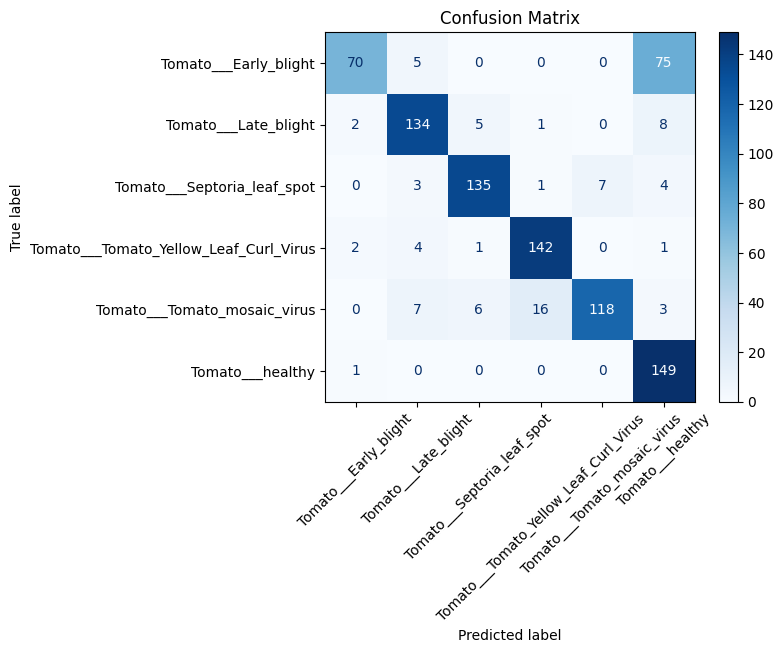

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Evaluate on test set ---
test_loss, test_acc = best_model.evaluate(test_ds, verbose=1)
print(f"✅ Test accuracy: {test_acc:.4f}   Test loss: {test_loss:.4f}")

# --- Collect predictions and true labels ---
y_true, y_pred = [], []
for batch_images, batch_labels in test_ds.unbatch().batch(64):
    preds = best_model.predict(batch_images, verbose=0)

    # Ensure preds is always 2D [batch, num_classes]
    preds = np.atleast_2d(preds)

    y_pred.extend(np.argmax(preds, axis=1).tolist())
    y_true.extend(batch_labels.numpy().tolist())

# --- Classification report ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Saving IMG-20240812-WA0219.jpg to IMG-20240812-WA0219.jpg
Saving IMG-20240812-WA0221.jpg to IMG-20240812-WA0221.jpg
Saving IMG-20240812-WA0223.jpg to IMG-20240812-WA0223 (1).jpg
Saving IMG-20240812-WA0265.jpg to IMG-20240812-WA0265.jpg
Saving IMG-20240812-WA0267.jpg to IMG-20240812-WA0267.jpg
Saving IMG-20240812-WA0303.jpg to IMG-20240812-WA0303.jpg


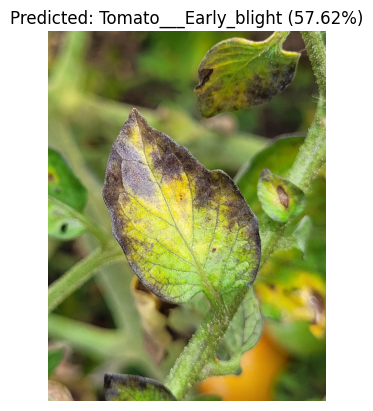

✅ File: IMG-20240812-WA0219.jpg
Predicted Class: Tomato___Early_blight
Confidence: 57.62%



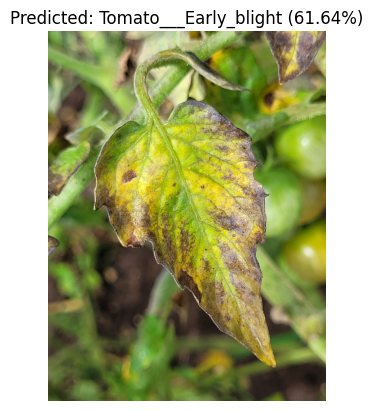

✅ File: IMG-20240812-WA0221.jpg
Predicted Class: Tomato___Early_blight
Confidence: 61.64%



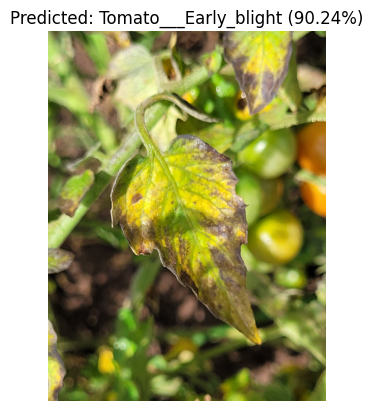

✅ File: IMG-20240812-WA0223 (1).jpg
Predicted Class: Tomato___Early_blight
Confidence: 90.24%



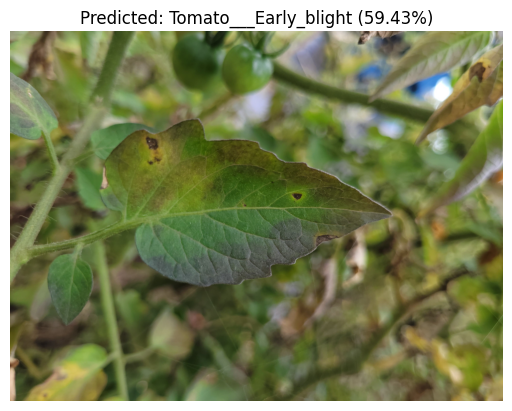

✅ File: IMG-20240812-WA0265.jpg
Predicted Class: Tomato___Early_blight
Confidence: 59.43%



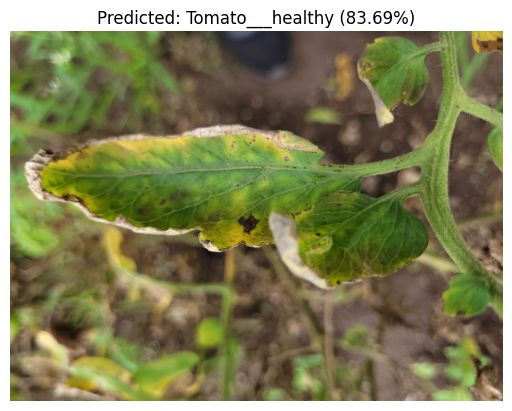

✅ File: IMG-20240812-WA0267.jpg
Predicted Class: Tomato___healthy
Confidence: 83.69%



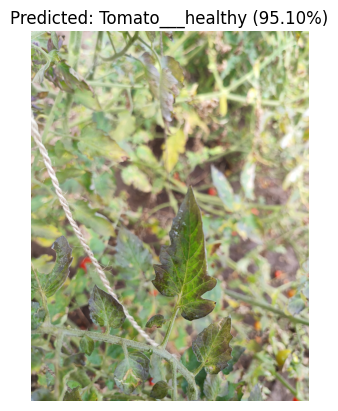

✅ File: IMG-20240812-WA0303.jpg
Predicted Class: Tomato___healthy
Confidence: 95.10%



In [15]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
import numpy as np
import matplotlib.pyplot as plt

# Upload image(s)
uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))  # same as training
    img_array = image.img_to_array(img)                     # to array
    img_array = np.expand_dims(img_array, axis=0)           # add batch dimension
    img_array = eff_preprocess(img_array)                   # EfficientNet preprocessing

    # Prediction
    preds = best_model.predict(img_array, verbose=0)
    preds = np.atleast_2d(preds)  # ensure 2D
    pred_class = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds)

    # Show image with prediction
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"Predicted: {class_names[pred_class]} ({confidence*100:.2f}%)")
    plt.show()

    print(f"✅ File: {fn}")
    print(f"Predicted Class: {class_names[pred_class]}")
    print(f"Confidence: {confidence*100:.2f}%\n")
